<a href="https://colab.research.google.com/github/SalarShafiee/Image-classification/blob/main/Alzymer%20-Finallll-%20salar-With%20TF.Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alzheimer MRI image classification**

# The problem

**"Alzheimer decease (AD) "** is the most common form of dementia and involves the progressive degeneration of brain cells, eventually causing a continuous decline in memory and cognitive functions, including the loss of basic capabilities and, eventually, death.

The cost of dealing with the disease currently stands at $1 trillion USD annually, while the number of affected people is expected to reach 152 million by 2050. Although there is no cure for AD,  **early diagnosis can help delay its progression, thus improving the quality of life for patients.**



# The solution and my code structure

**So as it is already explained, I want to predict the stage in which the patient currently is, so then we can probably stop progeressing the illnes.**

 the dataset is extarcted from kaggel.com and represented in four categories: "No Impairment", "Very Mild Impairment", "Mild Impairment", and "Moderate Impairment". each one represent a specific class of severness of the Alzheimer.

 By using Convelutional neural network (CNN) which is a type deep Neural network, we implement a classification task.

 Since our Image train size are not large enough to develope a Convelutional Neural network from vey first. I try to use Transfer learning by using **Xception** pretrained weights and structure.

# Link to the dataset

The dataset could be foung through this link: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy

#Content

1-Data and neccesary libraries download

2- Data preparation and exploratory analysis

3-Defining the CNN model structure

4- Model structure design and fine tuning
  
  4-2 test the best Hyperparameters

  4-3 CNN model structure

  4-4 callback definition

  4-5 model conpile

  4-6 model fit

5-Model evaluation
6-conclusion

#1-Data and neccesary libraries download

1-1 First we download the dataset from Kaggle directly on Colab

In [ ]:
import kagglehub

path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1


1-2 Then we import the neccessary Libraries from Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np

# 2- Data preparation and exploratory analysis

2-1  Our dataset does not have validation dataset, so we first define the path for Train, and Test dataset and then later will define the Validation data set.

In [ ]:
train_path='/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/train'
test_path='/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/test'

2-2  Here we will define the size of input Image and the mini-batch size of which we want to call and  feed to the CNN. since they are hyper parameters, these are the metrics we would change to see the effect on Validation loss / Validation accuracy.

In [ ]:
IMG_SIZE=[224,224]
BATCH_SIZE=8

2-3 We use tf.image_dataset_from_directory method, to get the images same as the image size already defined and as the batch size from respective directories and shuffle while extracting. thu shuffeling will help the model not to learn from the patterns of data.

tf.image_dataset_from_directory method, needs the folder organization to be in a specific format to recognize the label of each class and cound each photo in each class. our dataset directory already met the this condition !


As shown, we have 10240 images dedicated to 4 different classes.



In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 10240 files belonging to 4 classes.


2-4 We do the same for the Train data set.

In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1279 files belonging to 4 classes.


2-5 To have an overview of the class names of our data, we call class_names method on image_dataset_from_directory

In [ ]:
class_names = train_dataset.class_names
class_names

['Mild Impairment',
 'Moderate Impairment',
 'No Impairment',
 'Very Mild Impairment']

2-6 We can have also see if our training data is distrubuted evenly(balanced) between each classes. this way we can make sure our model is not trained in a biased way. otherwise we shoud implement some over/under sample or other methods of unsupervised balancing methods.

Here we can see that our data is moderatly balanced in each classes.

In [ ]:
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_dataset:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

print(class_counts)

{'Mild Impairment': 2560, 'Moderate Impairment': 2560, 'No Impairment': 2560, 'Very Mild Impairment': 2560}


2-6-1  this is a simple visualisation of quantity of each the data in each respective class

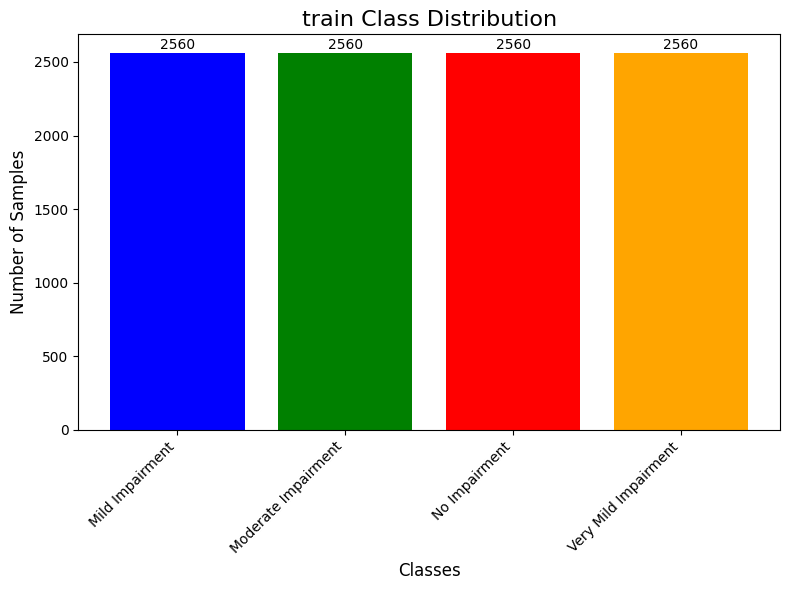

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(class_names, list(class_counts.values()), color=['blue', 'green', 'red', 'orange'])
plt.title('train Class Distribution', fontsize=16)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()


for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

2-7 Here we use Pilow library to look at at leat 1 image from each class, to be familier with the data

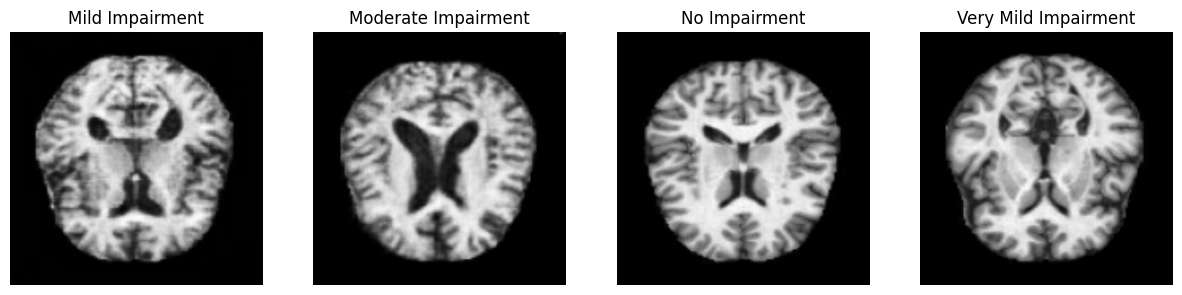

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Assuming you have 'train_dataset' and 'class_names'

# Get one sample per class
sample_images = []
sample_labels = []

for images, labels in train_dataset.take(1):
    for i in range(len(class_names)):
        index = np.where(labels.numpy() == i)[0]
        if len(index) > 0:
            sample_images.append(images[index[0]].numpy())
            sample_labels.append(class_names[i])

# Display images using Pillow and Matplotlib
fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))  # Adjust figsize as needed

for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    img = Image.fromarray(image.astype("uint8"))  # Convert to PIL Image
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()

2-8 As we saw above we do not have Validation batch, so in the following code we will make it. first with Cardinality method, we see on the Train data quantity and with the given bach number, how many sets of batches do we have?

In [ ]:
val_batches = tf.data.experimental.cardinality(train_dataset)
val_batches


<tf.Tensor: shape=(), dtype=int64, numpy=1280>

2-9 then with the following code, we get 80% of the training data for tarining. and take 20% of them to the validation_dataset.

In [ ]:

valid_dataset = train_dataset.take(val_batches // 5)
train_dataset = train_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_dataset))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of validation batches: 256
Number of train batches: 1024


# 3-Defining the CNN model structure

3-1 Use buffered prefetching to load images from disk without having I/O become blocking.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
Valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

3-2 this is the Augmentation layer, in order to make sure our model is more robust and does not overfit.

We have implemented one flip, rotation and random zoom to each batch of image.

We defined the augmentation as a layer, which then we will pass it to our model.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.3), width_factor=(-0.2,0.3), fill_mode='nearest'),

])


3-3 we have 10240 train image data. So, it is not that much big data to train from scratch, also it is not low that much to use just the weights from a pretrained model( specifically because it it a medical image).

So, we use transfer learning, but then we will fine-tune the model later to learn the latest layer with some specific features from our own dedicated data.

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

3-4 We will pass the shape structure of the image which is expected by the model.

Then we will say to the model to call and download the pretrained weight wich was trained on 'imagenet' dataset.

In [ ]:
IMG_SHAPE = IMG_SIZE + [3]
base_model = Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 4- Model structure design and fine tuning
As said above, we want to fine-tune the model to learn from our ouw dedicated data. So, I have unfreezed last 7 layers of the pretraind data to learn from my data and get more specific features.

Note: While fine tuning I should make sure the base starting learning rate in not high, and also When i unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, I should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model.

In [ ]:

for layer in base_model.layers[:-7]:
    layer.trainable = True  # Make sure they are trainable


I get a summary from the base model to seee the structure of the pretrained model.

In [ ]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

4-1 in Next three blocks, I will call one bacth and pass to the model, to see th output shape of the layers.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 7, 7, 2048)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 4)


4-2 This is table that I have shortly summarized the model with different hyperparameters.

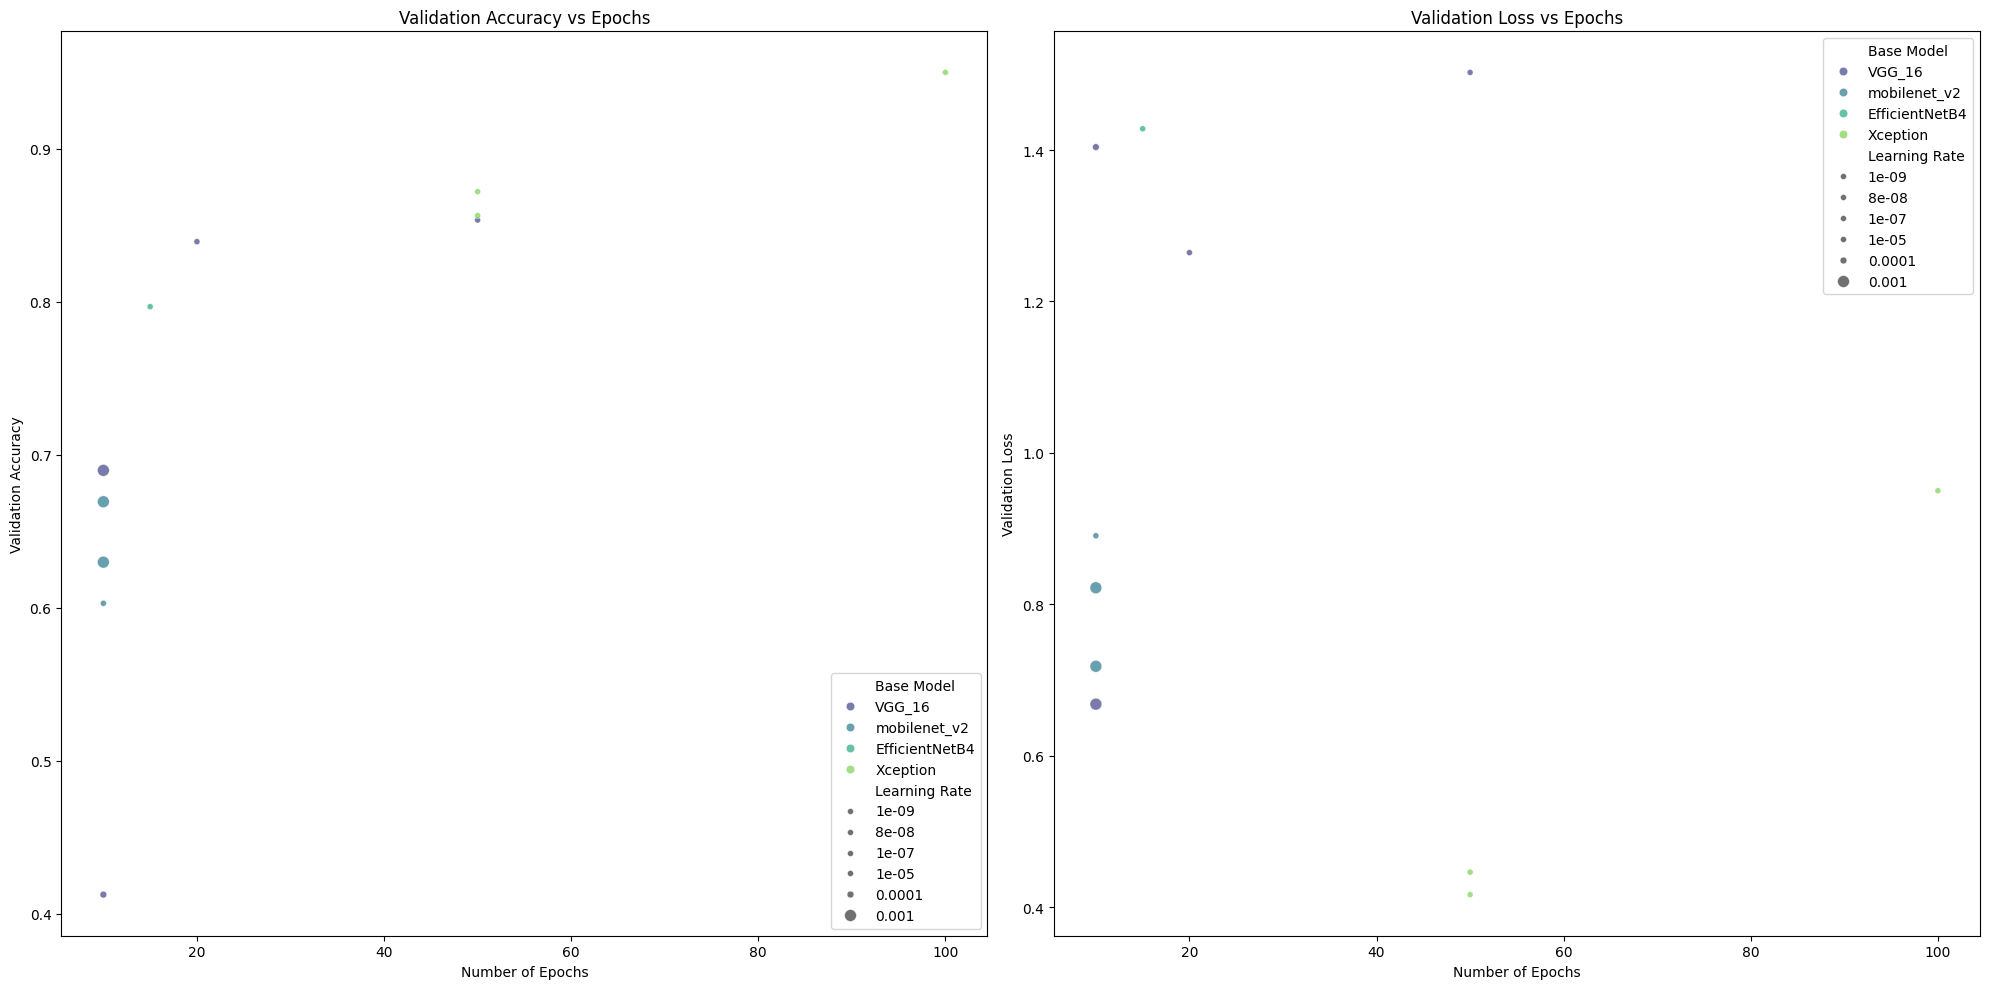

Image Size  Epochs     Base Model                 Fine Tune  Learning Rate                                                                                                            Model Build                            Augmentation  Validation Accuracy  Validation Loss
 224*224*3      10         VGG_16                     FALSE   1.000000e-03                                                                                       one global average + 20% dropout       none random flip +random rotation               0.6899           0.6680
 224*224*3      10         VGG_16                     FALSE   1.000000e-04                                                                                       one global average + 40% dropout flip, rotation, brightnes, sheers, zoom               0.4126           1.4039
 224*224*3      10   mobilenet_v2                     FALSE   1.000000e-03                                                                                       one global average + 40

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Image Size': ['224*224*3', '224*224*3', '224*224*3', '224*224*3', '224*224*3',
                   '224*224*2', '224*224*3', '224*224*3', '224*224*3', '224*224*3', '224*224*3'],
    'Epochs': [10, 10, 10, 10, 10, 15, 20, 50, 50, 50, 100],
    'Base Model': ['VGG_16', 'VGG_16', 'mobilenet_v2', 'mobilenet_v2', 'mobilenet_v2',
                   'EfficientNetB4', 'VGG_16', 'VGG_16', 'Xception', 'Xception', 'Xception'],
    'Fine Tune': ['FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE',
                  'TRUE (train 2 end layers)', 'TRUE (train 5 end layers)',
                  'TRUE (train 7 end layers)', 'TRUE (train 5 end layers)',
                  'TRUE (train 7 end layers)', 'TRUE (train 7 end layers)'],
    'Learning Rate': [0.001, 0.0001, 0.001, 0.001, 0.00001,
                      0.00001, 0.00001, 0.0000001, 0.00001, 0.000000001, 0.00000008],
    'Model Build': ['one global average + 20% dropout',
                    'one global average + 40% dropout',
                    'one global average + 40% dropout',
                    'one global average + 40% dropout + 2 dense layer each 1280 nodes relu',
                    'one global average + 20% dropout +30% dropout+ 2 dense layer each 1280 nodes leaky_relu',
                    'one global average + 30% dropout +20% dropout+ 2 dense layer each 1792 nodes +L1 regulizer(0.01) relu',
                    'one global average + 30% dropout +20% dropout+ 2 dense layer each 1792 nodes +L1 regulizer(0.01) relu',
                    'one global average + 30% dropout +20% dropout+ 2 dense layer each 1792 nodes +L1 regulizer(0.01) relu',
                    'one global average + 30% dropout +20% dropout+ 2 dense layer each 2048 nodes +L1 regulizer(0.01) relu',
                    'one global average + 20% dropout +40% dropout+ 2 dense layer one 512 and the other 2048 nodes +L1 regulizer(0.01) relu',
                    'one global average + 20% dropout +40% dropout+ 2 dense layer one 512 and the other 2048 nodes +L1 regulizer(0.01) relu'],
    'Augmentation': ['none random flip +random rotation',
                     'flip, rotation, brightnes, sheers, zoom',
                     'flip, rotation, brightnes, sheers, zoom',
                     'flip, rotation, brightnes, sheers, zoom',
                     'flip, rotation, brightnes, sheers, zoom',
                     'flip, rotation, brightnes, sheers, zoom',
                     'flip, rotation, brightnes, sheers, zoom',
                     'flip, rotation, brightnes, sheers, zoom',
                     'flip, rotation, brightnes, sheers, zoom',
                     'flip, rotation, brightnes, sheers, zoom',
                     'flip, rotation, brightnes, sheers, zoom'],
    'Validation Accuracy': [0.6899, 0.4126, 0.6299, 0.6694, 0.603,
                             0.7969, 0.8394, 0.8535, 0.8564, 0.8721, 0.95],
    'Validation Loss': [0.668, 1.4039, 0.8218, 0.718, 0.8905,
                        1.4281, 1.2645, 1.5025, 0.4461, 0.4164, 0.95]
}


df = pd.DataFrame(data)


plt.figure(figsize=(20, 10))


plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Epochs', y='Validation Accuracy',
                hue='Base Model', size='Learning Rate',
                palette='viridis', alpha=0.7)
plt.title('Validation Accuracy vs Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')


plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Epochs', y='Validation Loss',
                hue='Base Model', size='Learning Rate',
                palette='viridis', alpha=0.7)
plt.title('Validation Loss vs Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Loss')

plt.tight_layout()
plt.show()


print(df.to_string(index=False))

4-3  Here we implement the best model structure with the best Hyperparamethers we have **already tested on Validation data set.**

We use 2 drpopout to avoid overfitting and also we chose the "relu" activation.

Alo we use the Functional theme of keras to build our CNN model.

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2048, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Additional Dense layer
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

4-4 Call back definition

in this cell I define on earlystopping callback in order to stop learning if it is approaching the overfir.

also I add a modelchekpoint callback to save the weights after the best epoch.

also I add reduce_lr call method to decrease the learning rate if the learning curve is approaching the platue. (to achive higher performances)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau



early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True )


checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=0.000000001,
                              verbose=1)


4-5 model Compile

we use "SparseCategoricalCrossentropy" becasue our input is not one-hot

we use also from_logits=True to say to the model that I did not pass the softmax to the prediction layer.

In [ ]:
base_learning_rate=0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

4-6 Model fitting on Train and validation data

In [ ]:
# Fit the model with the callbacks
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=50,
                    callbacks=[checkpoint, early_stopping, reduce_lr]) # Add to callbacks

Epoch 1/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3844 - sparse_categorical_accuracy: 0.8826
Epoch 1: val_loss improved from 0.40934 to 0.37925, saving model to best_model.keras
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 113s 69ms/step - loss: 0.3844 - sparse_categorical_accuracy: 0.8826 - val_loss: 0.3793 - val_sparse_categorical_accuracy: 0.8799 - learning_rate: 1.0000e-05
Epoch 2/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3741 - sparse_categorical_accuracy: 0.8864
Epoch 2: val_loss did not improve from 0.37925
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 86s 67ms/step - loss: 0.3741 - sparse_categorical_accuracy: 0.8864 - val_loss: 0.3837 - val_sparse_categorical_accuracy: 0.8740 - learning_rate: 1.0000e-05
Epoch 3/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3513 - sparse_categorical_accuracy: 0.8953
Epoch 3: val_loss improved from 0.37925 to 0.34508, saving model to best_model.keras
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 87s 68ms/step - loss: 0.3513 - sparse_categorical_acc

# 5- Model evaluation
As we see above in the epoch 32 we reached 95% accuracy on validation data with specific hyperparameters.

here we look ad the trend of validation loss and accuracy!

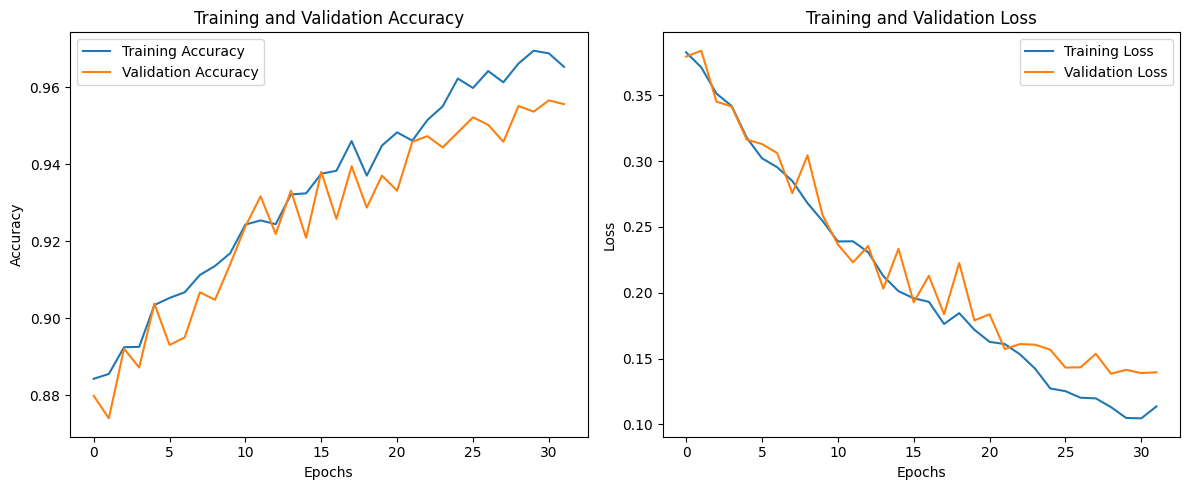

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
history_dict = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

5-1 since our data is balance, the accuracy seems to be a good metric to evaluate our performance. so, we chek the performance of our model on the unseen test data.

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3317 - sparse_categorical_accuracy: 0.8756
Test accuracy: 0.8827208876609802


# As We see we got 88% of accuracy on test data set with the best model.

#6- Conclusion
I used transfer learning, with the Xception model, to classify MRI images into those showing Alzheimer's disease and those that do not. I fine-tuned the model, prepared the data by augmentation, and optimized hyperparameters. My model reached an accuracy of 88% on the test set, showing a successful deep learning application for this task.
